#Lab7: Recommender Systems

---

We will use the MovieLense 1M ratings data (downloaded from http://www.grouplens.org/), which contains around 1,000,000 ratings (1-5) from 6,000 users on 4,000 movies.<br> 

<br>
<br>

**USERS FILE DESCRIPTION** <br>

User information is in the file "users.dat".<br>

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

<br>
<br>

**MOVIES FILE DESCRIPTION** <br>

Movie information is in the file "movies.dat" 

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:
	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

<br>
<br>

**RATINGS FILE DESCRIPTION** <br>

All ratings are contained in the file "ratings.dat" 
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Unix Timestamp is represented in seconds since the epoch (the number of seconds that have elapsed since January 1, 1970)
- Each user has at least 20 ratings

## 1: Upload and clean data

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from itertools import chain

In [ ]:
# Read user data
u_columns = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users = pd.read_csv('/content/drive/MyDrive/DL_data/users.dat', sep='::', names=u_columns, engine='python')
users

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [ ]:
# Read movie data
m_columns = ['movie_id', 'title', 'genre']
movies = pd.read_csv('/content/drive/MyDrive/DL_data/movies.dat', sep='::', names=m_columns, encoding='latin-1', engine='python')
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
# Read rating data
r_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/DL_data/ratings.dat', sep = '::', names=r_columns, engine='python')
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
MovieLense = pd.merge(movie_ratings, users)
MovieLense

,movie_id,title,genre,user_id,rating,timestamp,gender,age,occupation,zip_code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
1000204,3513,Rules of Engagement (2000),Drama|Thriller,5727,4,958489970,M,25,4,92843
1000205,3535,American Psycho (2000),Comedy|Horror|Thriller,5727,2,958489970,M,25,4,92843
1000206,3536,Keeping the Faith (2000),Comedy|Romance,5727,5,958489902,M,25,4,92843
1000207,3555,U-571 (2000),Action|Thriller,5727,3,958490699,M,25,4,92843


In [ ]:
# Show the head of data frame
MovieLense.head()

,movie_id,title,genre,user_id,rating,timestamp,gender,age,occupation,zip_code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067


## 2: Data Preprocessing

In [ ]:
# Encode movie_id and user_id
label_encoder = preprocessing.LabelEncoder()
ratings['movie_id'] = label_encoder.fit_transform(ratings['movie_id'])
ratings['user_id'] = label_encoder.fit_transform(ratings['user_id'])
ratings

,user_id,movie_id,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291
...,...,...,...,...
1000204,6039,1019,1,956716541
1000205,6039,1022,5,956704887
1000206,6039,548,5,956704746
1000207,6039,1024,4,956715648


In [ ]:
# Sort data based on 'user_id' and 'timestamp'
ratings = ratings.sort_values(by=['user_id', 'timestamp'])
ratings

,user_id,movie_id,rating,timestamp
31,0,2969,4,978300019
22,0,1178,5,978300055
27,0,1574,4,978300055
37,0,957,5,978300055
24,0,2147,3,978300103
...,...,...,...,...
1000019,6039,2709,4,997454429
999988,6039,1741,4,997454464
1000172,6039,1618,3,997454464
1000167,6039,155,3,997454486


In [ ]:
# Partition the data
test_data = ratings.drop_duplicates(subset=["user_id"], keep='last')
index_df = ratings.index.isin(test_data.index)
train_data = ratings.iloc[~index_df]
print(len(train_data), len(test_data))

994169 6040


In [ ]:
# Remove the timestamp column
train_data = train_data[['user_id', 'movie_id', 'rating']]
test_data = test_data[['user_id', 'movie_id', 'rating']]
print(train_data.shape, test_data.shape)

(994169, 3) (6040, 3)


## 3: Explore the MovieLense data

In [ ]:
# Total number of users
user_num = len(ratings['user_id'].unique())
user_num

6040

In [ ]:
# Total number of movies
movie_num = len(ratings['movie_id'].unique())
movie_num

3706

In [ ]:
# Rating information
ratings['rating'].mean()

3.581564453029317

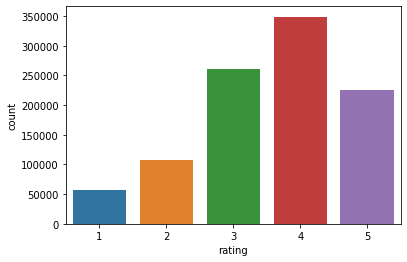

In [ ]:
# Rating distribution
sns.countplot(x='rating', data=ratings)

## 4: Collaborative Filtering Recommender Systems

In [ ]:
# Create user-item matrix for training and testing data
train_matrix = np.zeros([user_num, movie_num])
for line in train_data.itertuples():
  train_matrix[line.user_id, line.movie_id] = line.rating

test_matrix = np.zeros([user_num, movie_num])
for line in test_data.itertuples():
  test_matrix[line.user_id, line.movie_id] = line.rating

In [ ]:
# calculate the average rating for each user
average_user_rating = np.true_divide(train_matrix.sum(1),(train_matrix!=0).sum(1))

# create a train_matrix_sp represents users' preferences on different movies
train_matrix_sp = csr_matrix(train_matrix, dtype=np.float64)
nz = train_matrix_sp.nonzero()
train_matrix_sp[nz] -= average_user_rating[nz[0]]
train_matrix_sp = train_matrix_sp.toarray()

# calculate the user and movie similarity
user_similarity = pairwise_distances(train_matrix_sp)
movie_similarity = pairwise_distances(train_matrix_sp.T)
np.fill_diagonal(user_similarity, 0)
np.fill_diagonal(movie_similarity, 0)
print(user_similarity)
print(movie_similarity)

[[ 0.         12.14767903  8.60791228 ...  6.71762742  9.28739332
  22.25245423]
 [12.14767903  0.         13.13868334 ... 12.27293771 13.6762553
  24.57772784]
 [ 8.60791228 13.13868334  0.         ...  8.17151664 10.39955863
  23.11314879]
 ...
 [ 6.71762742 12.27293771  8.17151664 ...  0.          9.11528597
  22.44387565]
 [ 9.28739332 13.6762553  10.39955863 ...  9.11528597  0.
  22.75256405]
 [22.25245423 24.57772784 23.11314879 ... 22.44387565 22.75256405
   0.        ]]
[[ 0.         51.42939133 50.77085734 ... 43.72368622 43.56110292
  46.25164572]
 [51.42939133  0.         34.92245194 ... 26.87519199 26.53723702
  31.84088456]
 [50.77085734 34.92245194  0.         ... 25.24973951 24.97181356
  30.4472768 ]
 ...
 [43.72368622 26.87519199 25.24973951 ...  0.          9.17803742
  19.10977498]
 [43.56110292 26.53723702 24.97181356 ...  9.17803742  0.
  18.60010796]
 [46.25164572 31.84088456 30.4472768  ... 19.10977498 18.60010796
   0.        ]]


In [ ]:
# Create a collaborative filtering algorithm
zero_index = np.zeros(train_matrix_sp.shape)
zero_index[nz] = 1
def collaborative_filtering (type = 'user'):
  if type == 'user':
    pre_rating = average_user_rating[:, np.newaxis] + np.dot(user_similarity, train_matrix_sp)/np.dot(user_similarity, zero_index)
  if type == 'item':
    pre_rating = (np.dot(movie_similarity, train_matrix.T)/np.dot(movie_similarity, zero_index.T)).T
  return pre_rating


In [ ]:
# make predictions
user_prediction = collaborative_filtering(type='user')
item_prediction = collaborative_filtering(type='item')
user_prediction = np.nan_to_num(user_prediction, nan=4)
item_prediction = np.nan_to_num(item_prediction, nan=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
# Examine the evaluation results of user-based collaborative filtering on testing data: MAE and RMSE
MAE = mean_absolute_error(test_matrix[test_matrix!=0], user_prediction[test_matrix!=0])
RMSE = mean_squared_error(test_matrix[test_matrix!=0], user_prediction[test_matrix!=0], squared=False)
print("MAE:", MAE)
print("RMSE:", RMSE)

MAE: 0.7753529609966822
RMSE: 0.991180129199013


In [ ]:
# Examine the evaluation results of item-based collaborative filtering on testing data: MAE and RMSE
MAE = mean_absolute_error(test_matrix[test_matrix!=0], item_prediction[test_matrix!=0])
RMSE = mean_squared_error(test_matrix[test_matrix!=0], item_prediction[test_matrix!=0], squared=False)
print("MAE:", MAE)
print("RMSE:", RMSE)

MAE: 0.8958374281859105
RMSE: 1.1249154873319585


Q1. Which recommender system has better performance, user-based or item-based, and why? <br>


## 5: Neural Collaborative Filtering

In [ ]:
# Build a neural network on training data
class neural_network(nn.Module):
    def __init__(self,  emb_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, out_size):
        super().__init__()

        self.user_emb = nn.Embedding(user_num, emb_size)
        self.item_emb = nn.Embedding(movie_num, emb_size)
        
        self.network = nn.Sequential(
          nn.Linear(emb_size*2, hidden_size1),
          nn.ReLU(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, hidden_size3),
          nn.ReLU(),
          nn.Linear(hidden_size3, hidden_size4),
          nn.ReLU(),
          nn.Linear(hidden_size4, out_size))

    def forward(self, u_id, v_id):
        u = self.user_emb(u_id)
        v = self.item_emb(v_id)
        c = torch.cat([u,v], dim = 1)
        out = self.network(c)
        out_sig = torch.sigmoid(out) * 5.0
        return out_sig.squeeze()

In [ ]:
# Create tensor from pandas dataframe
train_user_tensor = torch.tensor(train_data['user_id'].values)
train_movie_tensor = torch.tensor(train_data['movie_id'].values)
train_rating_tensor = torch.tensor(train_data['rating'].values)
test_user_tensor = torch.tensor(test_data['user_id'].values)
test_movie_tensor = torch.tensor(test_data['movie_id'].values)
test_rating_tensor = torch.tensor(test_data['rating'].values)

# Create tensor dataset
train_dataset = torch.utils.data.TensorDataset(train_user_tensor.long(), train_movie_tensor.long(), train_rating_tensor.float())
test_dataset = torch.utils.data.TensorDataset(test_user_tensor.long(), test_movie_tensor.long(), test_rating_tensor.float())

# Define training and testing data loader, and set batch size to 512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 512, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 512, shuffle = True)

In [ ]:
# Define training loop function
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase 
        model.train()
        loss_train = 0.0
        for user_input, movie_input, labels in train_loader: # (user_input, movie_input, labels) are from (train_user_tensor, train_movie_tensor, train_rating_tensor) in train_dataset
                                                             # (user_input, movie_input, labels) are the inputs for each batch
            outputs = model(user_input, movie_input) # (user_input, movie_input) correspond to the u_id, v_id, which are the inputs of the forward(self, u_id, v_id) function
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs-1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))

In [ ]:
# Model training
torch.manual_seed(0)
NCF = neural_network(8, 128, 64, 32, 32, 1)
Adam_optimizer = optim.Adam(NCF.parameters(), lr = 0.02)
mse_loss = nn.MSELoss()

training_loop(n_epochs = 8, optimizer = Adam_optimizer, model = NCF, loss_fn=mse_loss, train_loader=train_loader)

Epoch 0, Training loss 0.8869118884773628
Epoch 1, Training loss 0.8205563066302809
Epoch 2, Training loss 0.8075245643681036
Epoch 3, Training loss 0.7994814229981415
Epoch 4, Training loss 0.7901962379225742
Epoch 5, Training loss 0.7734259794534296
Epoch 6, Training loss 0.7579839513488459
Epoch 7, Training loss 0.7496298095777277


In [ ]:
# Define testing function
def test(model, train_loader, test_loader):
 
  # testing phase
  model.eval()
  predict_train = []
  predict_test = []
  label_train = []
  label_test = []

  with torch.no_grad():
      for user_input, movie_input, labels in train_loader: # (user_input, movie_input, labels) are from (train_user_tensor, train_movie_tensor, train_rating_tensor) in train_dataset
                                                           # (user_input, movie_input, labels) are the inputs for each batch
          outputs = model(user_input, movie_input)         # (user_input, movie_input) correspond to the u_id, v_id, which are the inputs of the forward(self, u_id, v_id) function
          predict_train.append(outputs.tolist())
          label_train.append(labels.tolist())

      for user_input, movie_input, labels in test_loader: # (user_input, movie_input, labels) are from (test_user_tensor, test_movie_tensor, test_rating_tensor) in test_dataset
                                                          # (user_input, movie_input, labels) are the inputs for each batch
          outputs = model(user_input, movie_input)        # (user_input, movie_input) correspond to the u_id, v_id, which are the inputs of the forward(self, u_id, v_id) function
          predict_test.append(outputs.tolist())
          label_test.append(labels.tolist())
  
  MAE_train = mean_absolute_error(list(chain(*label_train)), list(chain(*predict_train)))
  RMSE_train = mean_squared_error(list(chain(*label_train)), list(chain(*predict_train)), squared=False)

  MAE_test = mean_absolute_error(list(chain(*label_test)), list(chain(*predict_test)))
  RMSE_test = mean_squared_error(list(chain(*label_test)), list(chain(*predict_test)), squared=False)

  print("Training MAE and RMSE:", MAE_train, RMSE_train)
  print()
  print("Testing MAE and RMSE:", MAE_test, RMSE_test)

In [ ]:
# Examine evaluation results
test(model = NCF, train_loader = train_loader, test_loader=test_loader)

Training MAE and RMSE: 0.6683394005368883 0.8520005597969494

Testing MAE and RMSE: 0.7322674098788508 0.9388386549964131


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/DL_Lab/Lab7_Recommender_Systems.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/DL_Lab/Lab7_Recommender_Systems.ipynb to html
[NbConvertApp] Writing 380390 bytes to /content/drive/MyDrive/DL_Lab/Lab7_Recommender_Systems.html
